In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from model.drone_model_jax import get_default_params, pack_params
from utils.swarm_utils import assemble_swarm, swarm_evalf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from utils.swarm_utils import assemble_swarm

all_targets = []

# --- Math Logic ---

def create_circle(cy, cz, scale, n):
    theta = np.linspace(0, 2*np.pi, n, endpoint=False)
    y = cy + scale * np.cos(theta)
    z = cz + scale * np.sin(theta)
    return np.column_stack((y, z))

def create_heart(cy, cz, scale, n):
    # Heart Curve Parametric Equation
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    # x = 16sin^3(t)
    # y = 13cos(t) - 5cos(2t) - 2cos(3t) - cos(4t)
    # Scale adjustment: basic heart is quite large, so divide by 16 to normalize roughly
    s = scale / 16.0 
    y = cy + s * 16 * np.sin(t)**3
    z = cz + s * (13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t))
    return np.column_stack((y, z))

def create_diamond(cy, cz, scale, n):
    # L1 Norm Circle (|y| + |z| = r)
    # Generate 4 segments
    n_side = max(1, n // 4)
    pts = []
    # 1. (0, r) -> (r, 0)
    pts.append(np.column_stack((np.linspace(0, scale, n_side), np.linspace(scale, 0, n_side))))
    # 2. (r, 0) -> (0, -r)
    pts.append(np.column_stack((np.linspace(scale, 0, n_side), np.linspace(0, -scale, n_side))))
    # 3. (0, -r) -> (-r, 0)
    pts.append(np.column_stack((np.linspace(0, -scale, n_side), np.linspace(-scale, 0, n_side))))
    # 4. (-r, 0) -> (0, r)
    pts.append(np.column_stack((np.linspace(-scale, 0, n_side), np.linspace(0, scale, n_side))))
    
    arr = np.vstack(pts)
    arr[:, 0] += cy
    arr[:, 1] += cz
    return arr

def create_spiral(cy, cz, scale, n):
    # Archimedean Spiral: r = a + b*theta
    # Loops: 3 turns (6pi)
    theta = np.linspace(0, 6*np.pi, n)
    r = np.linspace(0, scale, n)
    y = cy + r * np.cos(theta)
    z = cz + r * np.sin(theta)
    return np.column_stack((y, z))

def create_star(cy, cz, scale, n):
    # 5-Pointed Star
    # Connects outer radius (R) and inner radius (r)
    points = []
    n_points = 5
    R = scale
    r = scale * 0.4 # Inner radius
    
    # Vertices
    for i in range(n_points * 2 + 1):
        radius = R if i % 2 == 0 else r
        angle = i * np.pi / n_points + np.pi/2 # Start from top
        points.append([radius * np.cos(angle), radius * np.sin(angle)])
    
    points = np.array(points)
    # Interpolate along the edges
    final_pts = []
    total_perimeter_len = n # approximate distribution
    points_per_segment = max(1, n // (n_points * 2))
    
    for i in range(len(points)-1):
        p1, p2 = points[i], points[i+1]
        ts = np.linspace(0, 1, points_per_segment, endpoint=False)
        for t in ts:
            final_pts.append(p1 + t * (p2 - p1))
            
    arr = np.array(final_pts)
    arr[:, 0] += cy
    arr[:, 1] += cz
    return arr

def create_random_box(cy, cz, scale, n):
    # Uniform distribution inside a box
    y = cy + (np.random.rand(n) - 0.5) * 2 * scale
    z = cz + (np.random.rand(n) - 0.5) * 2 * scale
    return np.column_stack((y, z))

def create_line(cy, cz, scale, n):
    # Horizontal Line
    y = np.linspace(cy - scale, cy + scale, n)
    z = np.full(n, cz)
    return np.column_stack((y, z))


# --- UI ---
out_plot = widgets.Output()

# Options
shape_opts = ['Circle', 'Heart', 'Diamond', 'Spiral', 'Star', 'Random Box', 'Line']
w_shape = widgets.Dropdown(options=shape_opts, value='Heart', description='Shape:')
w_n = widgets.IntSlider(min=5, max=100, value=30, description='Count:')
w_pos_y = widgets.FloatSlider(min=-5, max=5, step=0.5, value=0, description='Center Y:')
w_pos_z = widgets.FloatSlider(min=0, max=6, step=0.5, value=2, description='Center Z:')
w_scale = widgets.FloatSlider(min=0.5, max=5, value=1.5, description='Size/Scale:')

btn_add = widgets.Button(description="Add Shape", button_style='success', icon='plus')
btn_undo = widgets.Button(description="Undo Last", button_style='warning', icon='undo')
btn_clear = widgets.Button(description="Reset All", button_style='danger', icon='trash')
lbl_status = widgets.Label(value="Select a shape and click Add.")

def get_current_shape_points():
    s = w_shape.value
    n = w_n.value
    cy, cz = w_pos_y.value, w_pos_z.value
    scale = w_scale.value
    
    if s == 'Circle': return create_circle(cy, cz, scale, n)
    elif s == 'Heart': return create_heart(cy, cz, scale, n)
    elif s == 'Diamond': return create_diamond(cy, cz, scale, n)
    elif s == 'Spiral': return create_spiral(cy, cz, scale, n)
    elif s == 'Star': return create_star(cy, cz, scale, n)
    elif s == 'Random Box': return create_random_box(cy, cz, scale, n)
    elif s == 'Line': return create_line(cy, cz, scale, n)
    return np.array([])

def update_plot():
    with out_plot:
        clear_output(wait=True)
        plt.figure(figsize=(6, 6))
        
        # Existing
        if len(all_targets) > 0:
            arr = np.vstack(all_targets)
            plt.scatter(arr[:, 0], arr[:, 1], c='gray', alpha=0.5, label='Added')
        
        # Preview
        temp_pts = get_current_shape_points()
        if len(temp_pts) > 0:
            plt.scatter(temp_pts[:, 0], temp_pts[:, 1], c='red', marker='x', s=20, label='Preview')
        
        plt.xlim(-6, 6)
        plt.ylim(-1, 7)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.axhline(0, color='k', linewidth=1)
        plt.title(f"Total Drones: {sum(len(x) for x in all_targets)}")
        plt.xlabel("y [m]")
        plt.ylabel("z [m]")
        plt.legend(loc='upper right')
        plt.show()

def on_add_click(b):
    new_pts = get_current_shape_points()
    all_targets.append(new_pts)
    lbl_status.value = f"Added {w_shape.value}."
    update_plot()

def on_undo_click(b):
    if all_targets:
        all_targets.pop()
        lbl_status.value = "Undid last shape."
        update_plot()

def on_clear_click(b):
    all_targets.clear()
    lbl_status.value = "Cleared all."
    update_plot()

# Connect
btn_add.on_click(on_add_click)
btn_undo.on_click(on_undo_click)
btn_clear.on_click(on_clear_click)

# Observe changes for real-time preview
for w in [w_shape, w_n, w_pos_y, w_pos_z, w_scale]:
    w.observe(lambda c: update_plot(), names='value')

# Layout
update_plot()
ui = widgets.VBox([
    widgets.HBox([w_shape, w_n]),
    widgets.HBox([w_pos_y, w_pos_z, w_scale]),
    widgets.HBox([btn_add, btn_undo, btn_clear, lbl_status]),
    out_plot
])
display(ui)

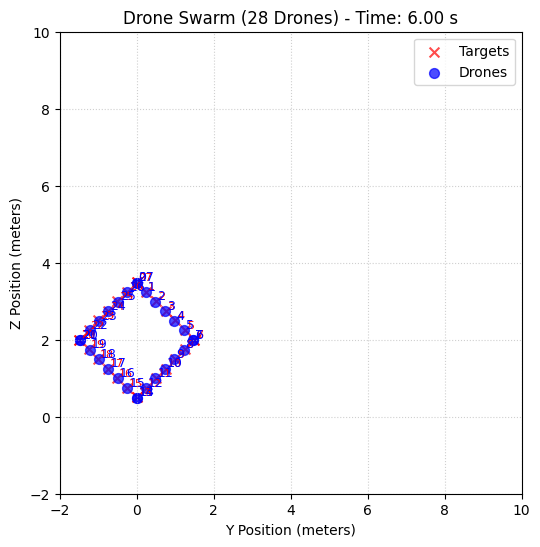

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from visualize import DroneVisualizer
from model.drone_model_jax import get_default_params, pack_params
from utils.swarm_utils import assemble_swarm, swarm_evalf

# --- INITIALIZATION ---
p = get_default_params()
p_tuple = pack_params(p)

targets = np.concatenate(all_targets, 0)
X0_flat, U = assemble_swarm(targets)
N = len(targets)

dt = 1e-3
T_final = 6
frame_skip = 50

x = X0_flat.copy()
t = 0.0
step = 0

# --- VISUALIZATION SETUP ---
# 1. Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# 2. Initialize the visualizer on these axes
viz = DroneVisualizer(ax, x, U, xlim=[-2, 10], ylim=[-2, 10])

# 3. Display the figure and get a handle to it
handle = display(fig, display_id=True)

# 4. Close the figure so it doesn't appear twice (once static, once dynamic)
plt.close(fig)

# --- SIMULATION LOOP ---
while t < T_final:
    dxdt = swarm_evalf(x, p_tuple, U)
    x = x + dxdt * dt
    t += dt
    step += 1

    if step % frame_skip == 0:
        # Update the data in the plot
        viz.update(x, t)

        # Push the updated figure to the display handle
        handle.update(fig)